# LCA for Holzhaus project 

- create new database 
- import data from excel into brightway (adding nodes and edges)
- calculate LCA  
    - calculate GWP potential (discounted) per scenario per year
    - calculate contribution of GWP per scenario per year 

# Import required packages

In [1]:
import bw2data as bd
import bw2io as bi
from pathlib import Path

In [2]:
import bw2data as bd
import bw2io as bi

PROJECT_NAME = "Holzhaus"

bi.restore_project_directory(
    fp='/etc/data/ecoinvent-3.10-cutoff-bw25.tar.gz',
    project_name=PROJECT_NAME,
    overwrite_existing=True
)
bd.projects.set_current(PROJECT_NAME)

Restoring project backup archive - this could take a few minutes...
Restored project: Holzhaus
07:02:20+0000 [info     ] Applying automatic update: 4.0 database search directories FTS5
07:02:20+0000 [info     ] Reindexing database ecoinvent-3.10-biosphere
07:02:20+0000 [info     ] Reindexing database ecoinvent-3.10-cutoff


# Import processes from excel to brightway 
This includes the processes timber production, construction, waste treatment, and electricity generation. 

To add: electricity generation. 

In [3]:
bd.projects.set_current(PROJECT_NAME)

In [4]:
imp = bi.ExcelImporter('LCA-2.xlsx')

Extracted 1 worksheets in 0.01 seconds


In [5]:
bd.databases

Databases dictionary with 2 object(s):
	ecoinvent-3.10-biosphere
	ecoinvent-3.10-cutoff

In [6]:
imp.apply_strategies()

Applying strategy: csv_restore_tuples
Applying strategy: csv_restore_booleans
Applying strategy: csv_numerize
Applying strategy: csv_drop_unknown
Applying strategy: csv_add_missing_exchanges_section
Applying strategy: normalize_units
Applying strategy: normalize_biosphere_categories
Applying strategy: normalize_biosphere_names
Applying strategy: strip_biosphere_exc_locations
Applying strategy: set_code_by_activity_hash
Applying strategy: link_iterable_by_fields
Applying strategy: assign_only_product_as_production
Applying strategy: link_technosphere_by_activity_hash
Applying strategy: drop_falsey_uncertainty_fields_but_keep_zeros
Applying strategy: convert_uncertainty_types_to_integers
Applying strategy: convert_activity_parameters_to_list
Applied 16 strategies in 0.06 seconds


the 'timber' database does not show up yet, because we haven't done the `imp.write_database()` command. we will run this after the database has been cleaned up. 

In [7]:
imp.statistics()

Graph statistics for `timber` importer:
4 graph nodes:
	None: 4
4 graph edges:
	technosphere: 4
0 edges to the following databases:
4 unique unlinked edges (4 total):
	technosphere: 4




(4, 4, 4, 0)

In [8]:
for edge, _ in zip(imp.unlinked, range(5)):
    print(edge)

{'name': 'market for structural timber', 'amount': 1.0, 'database': 'ecoinvent', 'location': 'RER', 'unit': 'cubic meter', 'type': 'technosphere', 'reference product': 'structural timber'}
{'name': 'building construction, hall, wood construction', 'amount': 1.0, 'database': 'ecoinvent', 'location': 'RoW', 'unit': 'square meter', 'type': 'technosphere', 'reference product': 'building, hall, wood construction'}
{'name': 'market for waste building wood, chrome preserved', 'amount': -1.0, 'database': 'ecoinvent', 'location': 'RoW', 'unit': 'kilogram', 'type': 'technosphere', 'reference product': 'waste building wood, chrome preserved'}
{'name': 'market for electricity, low voltage', 'amount': 1.0, 'database': 'ecoinvent', 'location': 'DE', 'unit': 'kilowatt hour', 'type': 'technosphere', 'reference product': 'electricity, low voltage'}


In [9]:
# match database according to fields 
imp.match_database("ecoinvent-3.10-cutoff", fields=('name', 'reference product', 'unit', 'location'))
imp.statistics()

Applying strategy: link_iterable_by_fields
Graph statistics for `timber` importer:
4 graph nodes:
	None: 4
4 graph edges:
	technosphere: 4
4 edges to the following databases:
	ecoinvent-3.10-cutoff: 4
0 unique unlinked edges (0 total):




(4, 4, 0, 0)

In [10]:
for edge in imp.unlinked:
    print(edge)

In [11]:
assert imp.all_linked

Graph statistics for `timber` importer:
4 graph nodes:
	None: 4
4 graph edges:
	technosphere: 4
4 edges to the following databases:
	ecoinvent-3.10-cutoff: 4
0 unique unlinked edges (0 total):




### Save excel processes to db

In [12]:
for node in imp.data:
    node["type"] = bd.labels.process_node_default

In [13]:
imp.write_database()

07:02:24+0000 [warning  ] Not able to determine geocollections for all datasets. This database is not ready for regionalization.


100%|██████████| 4/4 [00:00<00:00, 11707.76it/s]

07:02:24+0000 [info     ] Vacuuming database            


Created database: timber


In [14]:
bd.databases

Databases dictionary with 3 object(s):
	ecoinvent-3.10-biosphere
	ecoinvent-3.10-cutoff
	timber

In [15]:
for node in bd.Database("timber"):
    node["type"] = "process"
    node.save()

In [16]:
def print_db(label: str = "timber"):
    db = bd.Database(label)
    for index, node in enumerate(sorted(db, key=lambda x: x.id)):
        print(f"{index}: {node["type"]} {node}")
        for edge in node.exchanges():
            print(f"\t{edge}")
            print("\t", edge["type"], edge.input["type"], edge.output["type"], edge.input["database"], edge.output["database"])
        print()

In [17]:
print_db()

0: process 'timber production' (cubic meter, DE, None)
	Exchange: 1.0 cubic meter 'market for structural timber' (cubic meter, RER, None) to 'timber production' (cubic meter, DE, None)>
	 technosphere process process ecoinvent-3.10-cutoff timber

1: process 'construction' (square meter, RoW, None)
	Exchange: 1.0 square meter 'building construction, hall, wood construction' (square meter, RoW, None) to 'construction' (square meter, RoW, None)>
	 technosphere process process ecoinvent-3.10-cutoff timber

2: process 'waste treatment' (kilogram, RoW, None)
	Exchange: -1.0 kilogram 'market for waste building wood, chrome preserved' (kilogram, RoW, None) to 'waste treatment' (kilogram, RoW, None)>
	 technosphere process process ecoinvent-3.10-cutoff timber

3: process 'electricity production' (kilowatt hour, DE, None)
	Exchange: 1.0 kilowatt hour 'market for electricity, low voltage' (kilowatt hour, DE, None) to 'electricity production' (kilowatt hour, DE, None)>
	 technosphere process proce

# Add the rest of the nodes 
Right now, we have added the processes - timber production, construction, electricity production, and waste management. what's missing are 
- the other nodes, the products - timber, building, and CO2.
- all the edges between all the nodes

Now let's add the missing nodes and edges. 

In [18]:
db = bd.Database("timber")

In [19]:
# let's check what nodes and edges are already in the database
for node in bd.Database('timber'):
    print('node: ')
    print(node)
    print('Edges connected to node (above):')
    list(node.edges())
    print('\n\n')

node: 
'waste treatment' (kilogram, RoW, None)
Edges connected to node (above):



node: 
'construction' (square meter, RoW, None)
Edges connected to node (above):



node: 
'electricity production' (kilowatt hour, DE, None)
Edges connected to node (above):



node: 
'timber production' (cubic meter, DE, None)
Edges connected to node (above):





### Add housing lifecycle process node

In [20]:
housing_lifecycle = db.new_node(
    name="housing life cycle",
    location="DE",
    type=bd.labels.process_node_default
)
housing_lifecycle.save()

Let's manually add the technosphere nodes (and later, the edges in-between). 

As for the biophere nodes, we want to try directly adding them into the .xlsx file and import again. 

### Adding product nodes

In [21]:
timber = db.new_node(
    code="timber",
    name='timber',
    unit="cubic meter",
    type=bd.labels.product_node_default,
)
timber.save()
building = db.new_node(
    code="building",
    name='building',
    unit="square meter",
    type=bd.labels.product_node_default,
)
building.save()
waste_wood = db.new_node(
    code="ww",
    name='waste wood',
    unit="kilogram",
    type=bd.labels.product_node_default,
)
waste_wood.save()
housing_service = db.new_node(
    code="hs",
    name='wood-framed building services for Germany',
    type=bd.labels.product_node_default,
    unit='person-year', 
)
housing_service.save()
electricity = db.new_node(
    code="electricity",
    name='electricity use for housing lifecycle',
    unit="kWh",
    type=bd.labels.product_node_default,
)
electricity.save()

In [22]:
print_db()

0: process 'timber production' (cubic meter, DE, None)
	Exchange: 1.0 cubic meter 'market for structural timber' (cubic meter, RER, None) to 'timber production' (cubic meter, DE, None)>
	 technosphere process process ecoinvent-3.10-cutoff timber

1: process 'construction' (square meter, RoW, None)
	Exchange: 1.0 square meter 'building construction, hall, wood construction' (square meter, RoW, None) to 'construction' (square meter, RoW, None)>
	 technosphere process process ecoinvent-3.10-cutoff timber

2: process 'waste treatment' (kilogram, RoW, None)
	Exchange: -1.0 kilogram 'market for waste building wood, chrome preserved' (kilogram, RoW, None) to 'waste treatment' (kilogram, RoW, None)>
	 technosphere process process ecoinvent-3.10-cutoff timber

3: process 'electricity production' (kilowatt hour, DE, None)
	Exchange: 1.0 kilowatt hour 'market for electricity, low voltage' (kilowatt hour, DE, None) to 'electricity production' (kilowatt hour, DE, None)>
	 technosphere process proce

In [23]:
print('should have 10 nodes\n')
for i, node in enumerate(bd.Database('timber')):
    print(f'{i+1} - {node}')

should have 10 nodes

1 - 'wood-framed building services for Germany' (person-year, GLO, None)
2 - 'electricity production' (kilowatt hour, DE, None)
3 - 'electricity use for housing lifecycle' (kWh, GLO, None)
4 - 'waste treatment' (kilogram, RoW, None)
5 - 'building' (square meter, GLO, None)
6 - 'waste wood' (kilogram, GLO, None)
7 - 'timber' (cubic meter, GLO, None)
8 - 'housing life cycle' (None, DE, None)
9 - 'construction' (square meter, RoW, None)
10 - 'timber production' (cubic meter, DE, None)


### Adding all production edges

In [24]:
def add_production_edge(
        process_node_name, # name (string) of process node
        product_node, # node OBJECT of product node 
        negative=False
    ): 
    process_node = bd.get_node(name = process_node_name) # get node
    process_node.new_edge(
        input=product_node, # product being produced by process 
        amount=1 if negative==False else -1, # this is always 1 
        type=bd.labels.production_edge_default
    ).save() # make new edge and save 

In [25]:
add_production_edge_dict = {
    # process_node_name: product_node
    'timber production': timber, 
    'construction': building, 
   # 'housing life cycle': housing_service, 
   # 'waste treatment': waste_wood, 
    'electricity production': electricity,  
    # 'housing life cycle': waste_wood, # shouldn't be here, it's a consumption edge
}

In [26]:
# add production edges listed in the add_production_edge_dict
for process_node_name, product_node in add_production_edge_dict.items(): 
    #if process_node_name == 'waste treatment': 
    #    add_production_edge(process_node_name, product_node, negative=True)
    #else: 
    add_production_edge(process_node_name, product_node, negative=False)

In [27]:
print_db()

0: process 'timber production' (cubic meter, DE, None)
	Exchange: 1.0 cubic meter 'market for structural timber' (cubic meter, RER, None) to 'timber production' (cubic meter, DE, None)>
	 technosphere process process ecoinvent-3.10-cutoff timber
	Exchange: 1 cubic meter 'timber' (cubic meter, GLO, None) to 'timber production' (cubic meter, DE, None)>
	 production product process timber timber

1: process 'construction' (square meter, RoW, None)
	Exchange: 1.0 square meter 'building construction, hall, wood construction' (square meter, RoW, None) to 'construction' (square meter, RoW, None)>
	 technosphere process process ecoinvent-3.10-cutoff timber
	Exchange: 1 square meter 'building' (square meter, GLO, None) to 'construction' (square meter, RoW, None)>
	 production product process timber timber

2: process 'waste treatment' (kilogram, RoW, None)
	Exchange: -1.0 kilogram 'market for waste building wood, chrome preserved' (kilogram, RoW, None) to 'waste treatment' (kilogram, RoW, None)

In [28]:
housing_lifecycle = bd.get_node(name = 'housing life cycle')
housing_lifecycle.new_edge(
    input=housing_service,
    amount=1,
    functional=True,
    type=bd.labels.production_edge_default
).save()
housing_lifecycle.new_edge(
    input=waste_wood,
    amount=1,
    functional=False,
    type=bd.labels.production_edge_default
).save()
print(list(housing_lifecycle.edges()))

[Exchange: 1 person-year 'wood-framed building services for Germany' (person-year, GLO, None) to 'housing life cycle' (None, DE, None)>, Exchange: 1 kilogram 'waste wood' (kilogram, GLO, None) to 'housing life cycle' (None, DE, None)>]


### Adding consumption edges

In [29]:
# timber --> construction 
construction = bd.get_node(name='construction')
construction.new_edge(
    input=timber,
    amount=1,
    type=bd.labels.consumption_edge_default
).save()

In [30]:
# building --> housing life cycle 
housing_life_cycle = bd.get_node(name='housing life cycle')
housing_life_cycle.new_edge(
    input=building,
    amount=1,
    type=bd.labels.consumption_edge_default
).save()

# electricity --> housing lifecycle 
housing_life_cycle = bd.get_node(name='housing life cycle')
housing_life_cycle.new_edge(
    input=electricity,
    amount=1,
    type=bd.labels.consumption_edge_default
).save()

# housing life cycle --> waste wood 
#housing_life_cycle = bd.get_node(name='housing life cycle')
#housing_life_cycle.new_edge(
#    input=waste_wood,
#    amount=1,
#    type=bd.labels.consumption_edge_default
#).save()

In [31]:
# waste wood --> waste treatment
waste_treatment = bd.get_node(name='waste treatment')
waste_treatment.new_edge(
    input=waste_wood,
    amount=1,
    functional=True,
    type=bd.labels.consumption_edge_default
).save()


In [32]:
print_db()

0: process 'timber production' (cubic meter, DE, None)
	Exchange: 1.0 cubic meter 'market for structural timber' (cubic meter, RER, None) to 'timber production' (cubic meter, DE, None)>
	 technosphere process process ecoinvent-3.10-cutoff timber
	Exchange: 1 cubic meter 'timber' (cubic meter, GLO, None) to 'timber production' (cubic meter, DE, None)>
	 production product process timber timber

1: process 'construction' (square meter, RoW, None)
	Exchange: 1.0 square meter 'building construction, hall, wood construction' (square meter, RoW, None) to 'construction' (square meter, RoW, None)>
	 technosphere process process ecoinvent-3.10-cutoff timber
	Exchange: 1 square meter 'building' (square meter, GLO, None) to 'construction' (square meter, RoW, None)>
	 production product process timber timber
	Exchange: 1 cubic meter 'timber' (cubic meter, GLO, None) to 'construction' (square meter, RoW, None)>
	 technosphere product process timber timber

2: process 'waste treatment' (kilogram, Ro

In [33]:
ids = db.datapackage().data[4]
{x[1] for x in ids}.intersection({x[0] for x in ids})

set()

In [34]:
ids = db.datapackage().data[4]
len({x[1] for x in ids}), len({x[0] for x in ids}), len({x[0] for x in ids if x[0] > 1e6})

(5, 9, 5)

In [35]:
for x, y in db.datapackage().data[4]:
    print(bd.get_node(id=x), "\n\t", bd.get_node(id=y))

'market for waste building wood, chrome preserved' (kilogram, RoW, None) 
	 'waste treatment' (kilogram, RoW, None)
'market for electricity, low voltage' (kilowatt hour, DE, None) 
	 'electricity production' (kilowatt hour, DE, None)
'market for structural timber' (cubic meter, RER, None) 
	 'timber production' (cubic meter, DE, None)
'building construction, hall, wood construction' (square meter, RoW, None) 
	 'construction' (square meter, RoW, None)
'timber' (cubic meter, GLO, None) 
	 'timber production' (cubic meter, DE, None)
'timber' (cubic meter, GLO, None) 
	 'construction' (square meter, RoW, None)
'building' (square meter, GLO, None) 
	 'construction' (square meter, RoW, None)
'building' (square meter, GLO, None) 
	 'housing life cycle' (None, DE, None)
'waste wood' (kilogram, GLO, None) 
	 'waste treatment' (kilogram, RoW, None)
'waste wood' (kilogram, GLO, None) 
	 'housing life cycle' (None, DE, None)
'wood-framed building services for Germany' (person-year, GLO, None) 
	 

In [36]:
import bw2calc as bc

lca = bc.LCA({housing_service: 1})
lca.lci()

### Check if all nodes and edges have been added. 
- there should be 10 nodes
- and 13 edges: 9 we defined, 4 from ecoinvent  

In [37]:
for i, node in enumerate(bd.Database('timber')):
    print(f'{i+1}: {node}')

1: 'waste treatment' (kilogram, RoW, None)
2: 'housing life cycle' (None, DE, None)
3: 'waste wood' (kilogram, GLO, None)
4: 'wood-framed building services for Germany' (person-year, GLO, None)
5: 'electricity use for housing lifecycle' (kWh, GLO, None)
6: 'timber production' (cubic meter, DE, None)
7: 'construction' (square meter, RoW, None)
8: 'electricity production' (kilowatt hour, DE, None)
9: 'timber' (cubic meter, GLO, None)
10: 'building' (square meter, GLO, None)


In [38]:
edges_all = []
for node in bd.Database('timber'): 
    for edge in node.edges(): 
        edges_all.append(edge)

for i, edge in enumerate(edges_all): 
    print(f'{i+1}: {edge}')

1: Exchange: 1 person-year 'wood-framed building services for Germany' (person-year, GLO, None) to 'housing life cycle' (None, DE, None)>
2: Exchange: 1 kilogram 'waste wood' (kilogram, GLO, None) to 'housing life cycle' (None, DE, None)>
3: Exchange: 1 square meter 'building' (square meter, GLO, None) to 'housing life cycle' (None, DE, None)>
4: Exchange: 1 kWh 'electricity use for housing lifecycle' (kWh, GLO, None) to 'housing life cycle' (None, DE, None)>
5: Exchange: 1.0 square meter 'building construction, hall, wood construction' (square meter, RoW, None) to 'construction' (square meter, RoW, None)>
6: Exchange: 1 square meter 'building' (square meter, GLO, None) to 'construction' (square meter, RoW, None)>
7: Exchange: 1 cubic meter 'timber' (cubic meter, GLO, None) to 'construction' (square meter, RoW, None)>
8: Exchange: 1.0 cubic meter 'market for structural timber' (cubic meter, RER, None) to 'timber production' (cubic meter, DE, None)>
9: Exchange: 1 cubic meter 'timber' (

# Adding parameters
This is where we start connecting with Chris' notebook. We add the following parameters, and use these parameters to over-write all the consumption edges in our graph. 
* `timber_use` - Timber (kg) used in new housing construction (m2)
* `housing_addition` - Annual housing construction (m2) added to total housing stock
* `electricity_consumption` - Electricity consumption (kWh) used in total housing stock
* `housing_waste` - Solid waste (kg) produced by total housing stock

### Get info from MFA (.csv file)

In [39]:
import pandas as pd
import numpy as np

In [40]:
# need to double check the unit conversions 
# material_intensity unit: ton / m2 
# inflow unit: ton 
# housing_addition (h_a) unit: m2 
# timber use in m3 (t_u) 
# outflow of timber in m3 (w_w)

# read tables
df = pd.read_csv('input_timber_share.csv')
df = df.clip(lower=0)
df2 = pd.read_csv('input_lifetime.csv')
df2 = df2.clip(lower=0)
df3 = pd.read_csv('population.csv')
df4 = pd.read_csv('Timber_intensity_ouflows.csv')

# calculate electricity consumption for german households
# per capita electricity consumption times population
# unit kWh
population = df3['Total Population']
electricity_total = np.array(population * 1565.560375)

# Baseline
h_a_baseline = np.array(df.inflow_baseline / 0.035)
t_u_baseline = h_a_baseline * 0.035 * 1000 / 396
w_w_baseline = np.array(df2['Outflow_Baseline'] * 0.035 * 1000 / 396)

# S1 - Higher timber share
h_a_s1 = df.inflow_s1 * 1 / df.material_intensity_s1 # housing_addition unit: square meter 
t_u_s1 = h_a_s1 * df.material_intensity_s1 * 1000 / 396 # timber_use unit: kilogram 
w_w_s1 = df4['Outflow_s1'] * 0.035 * 1000 / 396

# S2 - 20yr lifetime
h_a_s2 = df2['Inflow_l_20yr'] / 0.035
t_u_s2 = h_a_s2 * 0.035 * 1000 / 396
w_w_s2 = df2['Outflow_l_20yr'] * 0.035 * 1000 / 396

# S3 - 50yr lifetime
h_a_s3 = df2['Inflow_l_50yr'] / 0.035
t_u_s3 = h_a_s3 * 0.035 * 1000 / 396
w_w_s3 = df2['Outflow_l_50yr'] * 0.035 * 1000 / 396

# S4 - 125yr lifetime
h_a_s4 = df2['Inlow_l_125yr'] / 0.035
t_u_s4 = h_a_s4 * 0.035 * 1000 / 396
w_w_s4 = df2['Outlow_l_125yr'] * 0.035 * 1000 / 396

housing_addition_array = np.array(h_a_baseline)

### Add parameters into bw model
* `timber_use` - Timber (m3) used in new housing construction (m2)
* `housing_addition` - Annual housing construction (m2) added to total housing stock
* `electricity_consumption` - Electricity consumption (kWh) used in total housing stock
* `housing_waste` - Solid waste (kg) produced by total housing stock

In [41]:
from dataclasses import dataclass
import numpy as np

In [42]:
@dataclass
class DataArray:
    product: bd.Node
    process: bd.Node
    array: np.ndarray
    consumption: bool = True

In [43]:
import bw_processing as bwp

def data_obj_for_arrays(arrays: list[DataArray]) -> bwp.Datapackage:
    for dc in arrays:
        assert isinstance(dc, DataArray), "Oops, wrong input type"

    data_array = np.vstack([dc.array for dc in arrays])
    indices_array = np.array(
        [(dc.product.id, dc.process.id) for dc in arrays], 
        dtype=bwp.INDICES_DTYPE
    )
    flip_array = np.array([dc.consumption for dc in arrays])
    dp = bwp.create_datapackage(
        sequential=True
    )
    dp.add_persistent_array(
        matrix="technosphere_matrix",
        indices_array=indices_array,
        data_array=data_array,
        flip_array=flip_array,
    )
    return dp

# Calculate LCA 

In [44]:
# define parameter for baseline
timber_use = DataArray(
    product=timber,
    process=construction,
    array=t_u_baseline, 
)
housing_addition = DataArray(
    product=building,
    process=housing_lifecycle,
    array=h_a_baseline, 
)
electricity_consumption = DataArray(
    product=electricity,
    process=housing_lifecycle,
    array=electricity_total
)
housing_waste = DataArray(
    product=waste_wood,
    process=housing_lifecycle,
    array=w_w_baseline,
    consumption=False,
)

In [45]:
# calculate LCA for Baseline
dp = data_obj_for_arrays([
    timber_use,
    housing_addition,
    electricity_consumption,
    housing_waste
])
import bw2calc as bc
ipcc = ('IPCC 2021', 'climate change', 'global warming potential (GWP100)')
functional_unit, data_objs, _ = bd.prepare_lca_inputs({housing_service: 1}, method=ipcc)
lca = bc.LCA(functional_unit, data_objs = data_objs + [dp], use_arrays=True)
lca.lci()
lca.lcia()
results_baseline = []
results_baseline.append(lca.score) # 1st score 
for i in range(len(housing_addition_array) - 1):
    next(lca)
    print(lca.score)
    results_baseline.append(lca.score)

51483639082.70024
51364405858.303246
51235812391.055504
51101736802.08768
50960828388.910675
50825706421.72679
50679847686.067024
50544425086.74891
50404517563.62415
50277473385.476875
50142934865.17921
49998951874.92916
49864436720.66598
49724876565.746475
49589024238.338684
49456490573.85681
49335630628.56887
49214819255.192955
49081137778.93332
48941208150.645966
48801016009.03269
48661675976.6205
48517993040.87204
48362644385.77992
48210353722.96753
48059828754.8834
47907659217.11679
47755431279.46448
47586716405.85567
47409825387.2862
47232013412.834885
47061469544.20127
46889101586.9223
46718405876.833466
46559909538.70659
46402670461.58683
46260951260.91559
46119274487.30567
45988693529.24051
45863720116.83653
45744361627.2928
45624780587.32762
45509718905.81527
45406516612.80133
45304349022.54693
45212877628.605286
45112234119.36171
45018601112.55989
44919251133.62208
44822470995.564255
44738899100.119026
44641383666.00523
44544350843.11286
653197155488.4052
7698550433111.772
2

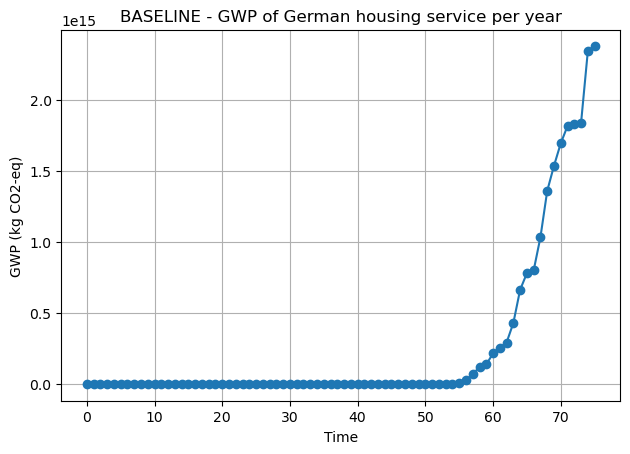

In [46]:
# ploting for baseline
import matplotlib.pyplot as plt
plt.plot(results_baseline, marker='o')  # Adds dots to each point
plt.title("BASELINE - GWP of German housing service per year")
plt.xlabel("Time")
plt.ylabel("GWP (kg CO2-eq)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [47]:
# define parameter for S1 - Higher timber share (70yr lifetime)
timber_use = DataArray(
    product=timber,
    process=construction,
    array=t_u_s1, 
)
housing_addition = DataArray(
    product=building,
    process=housing_lifecycle,
    array=h_a_s1, 
)
electricity_consumption = DataArray(
    product=electricity,
    process=housing_lifecycle,
    array=electricity_total
)
housing_waste = DataArray(
    product=waste_wood,
    process=housing_lifecycle,
    array=w_w_s1,
    consumption=False,
)

In [48]:
# calculate LCA for S1
dp = data_obj_for_arrays([
    timber_use,
    housing_addition,
    electricity_consumption,
    housing_waste
])
import bw2calc as bc
ipcc = ('IPCC 2021', 'climate change', 'global warming potential (GWP100)')
functional_unit, data_objs, _ = bd.prepare_lca_inputs({housing_service: 1}, method=ipcc)
lca = bc.LCA(functional_unit, data_objs = data_objs + [dp], use_arrays=True)
lca.lci()
lca.lcia()
results_s1 = []
results_s1.append(lca.score) # 1st score 
for i in range(len(housing_addition_array) - 1):
    next(lca)
    print(lca.score)
    results_s1.append(lca.score)

51483637626.91859
353974086385041.56
272848425370344.34
230419684863787.4
183297960232962.06
225068594125758.84
155895702855806.97
230432038948151.3
204220507805228.62
313772295167425.1
263031241812805.5
204542213411454.5
292999113678272.25
270501384762592.84
325096516648666.5
385174812849556.4
548241691690670.6
597635254840040.2
500954908674635.0
487759329678120.75
548507577723840.56
634384847383248.2
666222975072056.9
612794745975293.9
759968607252056.6
914755193000669.8
1040418285018490.0
1215544304601457.2
1122855920321043.9
1186689943237259.8
1401438485510548.2
1825692133807075.2
2109442765620084.5
2524094376054612.5
3303040088701542.5
3860150526870193.0
4994240797367351.0
5693183555930410.0
6936488740190688.0
8082857888702877.0
9352787271064276.0
1.0438951059888162e+16
1.188286100059579e+16
1.3898040733643926e+16
1.5395294735270466e+16
1.7655631018242572e+16
1.8648008799019908e+16
2.0880256115762944e+16
2.2239069431078144e+16
2.4306719418047776e+16
2.737129517319695e+16
2.8147931

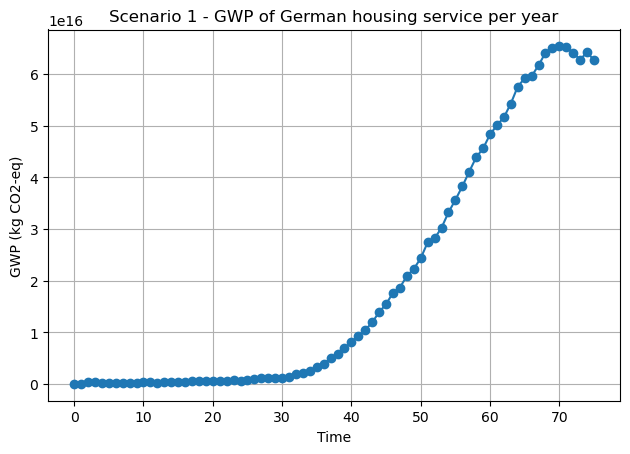

In [49]:
# ploting for S1
import matplotlib.pyplot as plt
plt.plot(results_s1, marker='o')  # Adds dots to each point
plt.title("Scenario 1 - GWP of German housing service per year")
plt.xlabel("Time")
plt.ylabel("GWP (kg CO2-eq)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [50]:
# define parameter for S2 - 20yr life time
timber_use = DataArray(
    product=timber,
    process=construction,
    array=t_u_s2, 
)
housing_addition = DataArray(
    product=building,
    process=housing_lifecycle,
    array=h_a_s2, 
)
electricity_consumption = DataArray(
    product=electricity,
    process=housing_lifecycle,
    array=electricity_total
)
housing_waste = DataArray(
    product=waste_wood,
    process=housing_lifecycle,
    array=w_w_s2,
    consumption=False,
)

In [51]:
# calculate LCA for S2
dp = data_obj_for_arrays([
    timber_use,
    housing_addition,
    electricity_consumption,
    housing_waste
])
import bw2calc as bc
ipcc = ('IPCC 2021', 'climate change', 'global warming potential (GWP100)')
functional_unit, data_objs, _ = bd.prepare_lca_inputs({housing_service: 1}, method=ipcc)
lca = bc.LCA(functional_unit, data_objs = data_objs + [dp], use_arrays=True)
lca.lci()
lca.lcia()
results_s2 = []
results_s2.append(lca.score) # 1st score 
for i in range(len(housing_addition_array) - 1):
    next(lca)
    print(lca.score)
    results_s2.append(lca.score)

51483639174.09021
51364406027.28063
51235812684.17629
51101737287.8161
121431899953236.31
1133016140366290.8
3569102006852947.5
9925349968709492.0
2.1211108881283776e+16
4.242537906995576e+16
7.355070685503522e+16
1.1858766786734243e+17
1.831655670723564e+17
2.605470779415397e+17
3.5152238392086944e+17
4.465312002320627e+17
5.382771910543177e+17
6.086844211396632e+17
6.470472616662255e+17
6.554076336649015e+17
6.336169173481494e+17
5.848748715404204e+17
5.158011154681674e+17
4.36474836139138e+17
3.634501690410873e+17
2.98359697569409e+17
2.4482296995092403e+17
2.0546267945454483e+17
1.7601029351484608e+17
1.6028128007734717e+17
1.5610252244382253e+17
1.6211466329442083e+17
1.7367505653422282e+17
1.9182642233314342e+17
2.166338334931861e+17
2.415459349033153e+17
2.7031414962349862e+17
2.9354845187681395e+17
3.159857109757056e+17
3.318122137840475e+17
3.415513909557117e+17
3.4330991395382176e+17
3.404619134777043e+17
3.346221038433116e+17
3.219857990387461e+17
3.0960362969706176e+17
2.91

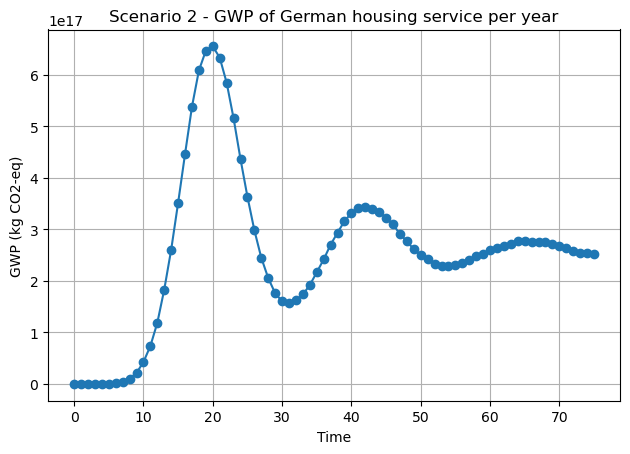

In [52]:
# ploting for S2
import matplotlib.pyplot as plt
plt.plot(results_s2, marker='o')  # Adds dots to each point
plt.title("Scenario 2 - GWP of German housing service per year")
plt.xlabel("Time")
plt.ylabel("GWP (kg CO2-eq)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [53]:
# define parameter for S3 - 50yr life time
timber_use = DataArray(
    product=timber,
    process=construction,
    array=t_u_s3, 
)
housing_addition = DataArray(
    product=building,
    process=housing_lifecycle,
    array=h_a_s3, 
)
electricity_consumption = DataArray(
    product=electricity,
    process=housing_lifecycle,
    array=electricity_total
)
housing_waste = DataArray(
    product=waste_wood,
    process=housing_lifecycle,
    array=w_w_s3,
    consumption=False,
)

In [54]:
# calculate LCA for S3
dp = data_obj_for_arrays([
    timber_use,
    housing_addition,
    electricity_consumption,
    housing_waste
])
import bw2calc as bc
ipcc = ('IPCC 2021', 'climate change', 'global warming potential (GWP100)')
functional_unit, data_objs, _ = bd.prepare_lca_inputs({housing_service: 1}, method=ipcc)
lca = bc.LCA(functional_unit, data_objs = data_objs + [dp], use_arrays=True)
lca.lci()
lca.lcia()
results_s3 = []
results_s3.append(lca.score) # 1st score 
for i in range(len(housing_addition_array) - 1):
    next(lca)
    print(lca.score)
    results_s3.append(lca.score)

51483639095.06192
51364405875.67933
51235812414.76197
51101736833.82714
50960828430.664604
50825706475.84934
50679847755.33359
50544425174.40825
50404517673.44416
50277473521.80245
50142935032.97456
49998952079.82989
49864436969.01251
49724876864.61977
49589024595.588684
49456490998.10709
5348832123707.978
50326425714069.2
86908158178652.12
188089206834480.28
405763293865868.2
754057956105975.9
1167118051177852.8
1579968441814515.5
2451484207767198.0
3551871908125445.0
4826906476220986.0
6450920827603420.0
7700752886866579.0
9540297729820766.0
1.2047528089639406e+16
1.5416387078951508e+16
1.867070525344294e+16
2.253651870521089e+16
2.7618326700576988e+16
3.224423570404814e+16
3.849148532933047e+16
4.359545232295369e+16
5.0005885062824216e+16
5.596307412867675e+16
6.191392643080602e+16
6.701611687002506e+16
7.243715413192678e+16
7.84816073702168e+16
8.261709216576224e+16
8.752313907620912e+16
8.89374965041322e+16
9.192377923852318e+16
9.227562065384302e+16
9.302742719738963e+16
9.453919

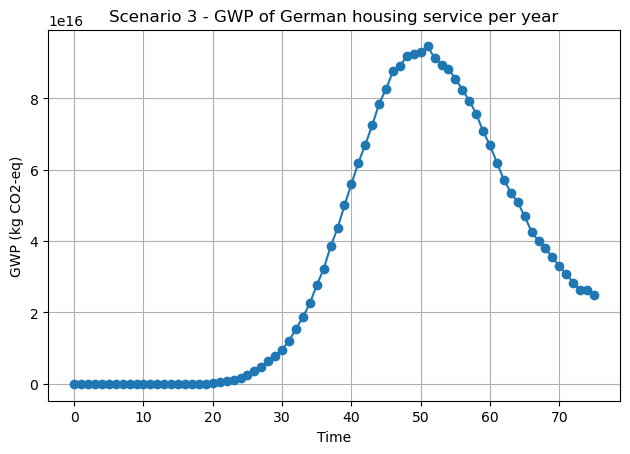

In [55]:
# ploting for S3
import matplotlib.pyplot as plt
plt.plot(results_s3, marker='o')  # Adds dots to each point
plt.title("Scenario 3 - GWP of German housing service per year")
plt.xlabel("Time")
plt.ylabel("GWP (kg CO2-eq)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [56]:
# define parameter for S4 - 125yr life time
timber_use = DataArray(
    product=timber,
    process=construction,
    array=t_u_s4, 
)
housing_addition = DataArray(
    product=building,
    process=housing_lifecycle,
    array=h_a_s4, 
)
electricity_consumption = DataArray(
    product=electricity,
    process=housing_lifecycle,
    array=electricity_total
)
housing_waste = DataArray(
    product=waste_wood,
    process=housing_lifecycle,
    array=w_w_s4,
    consumption=False,
)

In [57]:
# calculate LCA for S4
dp = data_obj_for_arrays([
    timber_use,
    housing_addition,
    electricity_consumption,
    housing_waste
])
import bw2calc as bc
ipcc = ('IPCC 2021', 'climate change', 'global warming potential (GWP100)')
functional_unit, data_objs, _ = bd.prepare_lca_inputs({housing_service: 1}, method=ipcc)
lca = bc.LCA(functional_unit, data_objs = data_objs + [dp], use_arrays=True)
lca.lci()
lca.lcia()
results_s4 = []
results_s4.append(lca.score) # 1st score 
for i in range(len(housing_addition_array) - 1):
    next(lca)
    print(lca.score)
    results_s4.append(lca.score)

51483639069.96698
51364405842.29956
51235812371.2551
51101736777.76875
50960828359.31967
50825706386.0097
50679847643.26211
50544425035.77283
50404517503.26857
50277473314.38907
50142934781.85947
49998951777.71258
49864436607.71988
49724876435.05636
49589024087.69327
49456490400.84482
49335630430.56571
49214819029.35362
49081137522.183624
48941207859.6815
48801015680.31454
48661675606.37045
48517992625.07135
48362643920.17303
48210353203.068695
48059828175.98493
47907658574.29505
47755430567.59815
47586715619.643074
47409824521.266785
47232012461.41791
47061468501.69057
46889100447.549065
46718404634.79234
46559908188.20062
46402668996.868546
46260949676.333176
46119272777.358284
45988691688.62608
45863718140.514465
45744359510.53587
45624778325.78404
45509716495.56836
45406514050.429634
45304346305.18191
45212874753.98707
45112231085.89981
45018597919.380196
44919247780.62232
44822467483.45049
44738895430.45007
44641379841.2211
44544346866.55872
653197151326.8271
7698550427720.466
266

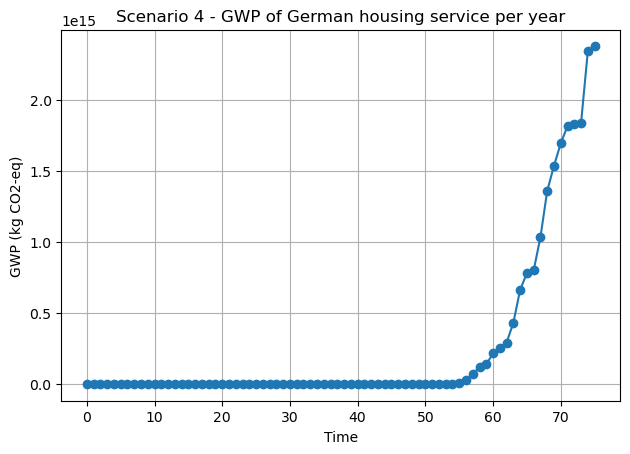

In [58]:
# ploting for S4
import matplotlib.pyplot as plt
plt.plot(results_s4, marker='o')  # Adds dots to each point
plt.title("Scenario 4 - GWP of German housing service per year")
plt.xlabel("Time")
plt.ylabel("GWP (kg CO2-eq)")
plt.grid(True)
plt.tight_layout()
plt.show()

### GWP (discounted) per scenario per year 

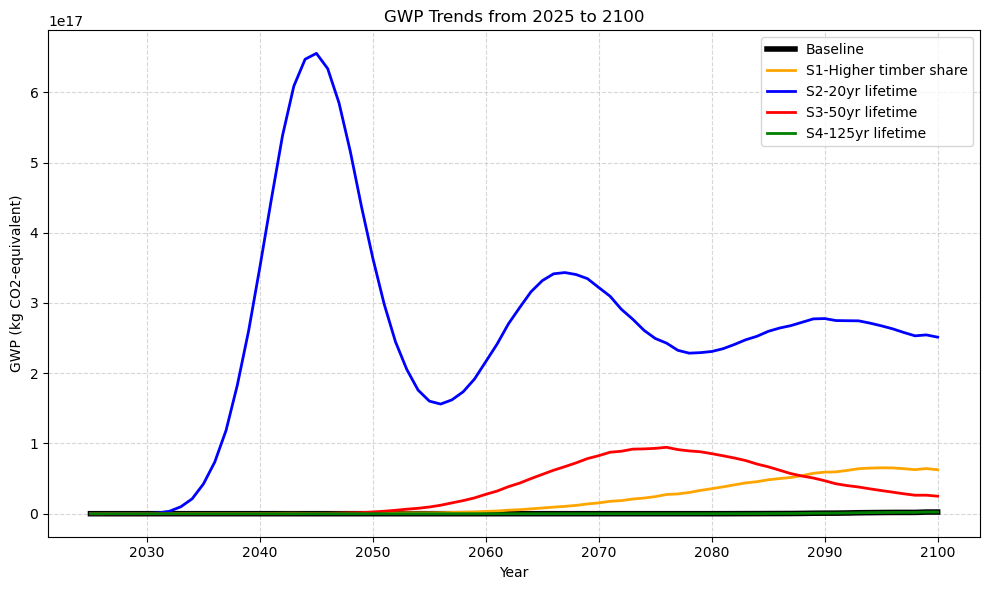

In [59]:
df = pd.DataFrame({
    "Year": list(range(2025, 2101)),
    "Baseline": results_baseline,
    "S1-Higher timber share": results_s1,
    "S2-20yr lifetime": results_s2,
    "S3-50yr lifetime": results_s3,
    "S4-125yr lifetime": results_s4,
})

plt.figure(figsize=(10, 6))

# Define colors for each line
line_colors = {
    "S1-Higher timber share": 'orange',  
    "S2-20yr lifetime": 'blue',  
    "S3-50yr lifetime": 'red', 
    "S4-125yr lifetime": 'green' 
}

# Plot each list as a line against year with manual color assignments
for col in df.columns[1:]:
    if col == "Baseline":
        plt.plot(df["Year"], df[col], label=col, linewidth=4, color='black')  # thicker line for Baseline
    else:
        plt.plot(df["Year"], df[col], label=col, linewidth=2, color=line_colors.get(col, 'black'))  # Default to black if no color specified

plt.xlabel("Year")
plt.ylabel("GWP (kg CO2-equivalent)")
plt.title("GWP Trends from 2025 to 2100")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()